Model training, hyper-parameter tuning and cross-validation

In [614]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [615]:
# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

Screening questionnaire (feature selection)

In [616]:
# load the screening questionnaire 
#screening_questions = pd.read_csv('screening_questions.csv', sep=';')
#screening_questions = pd.read_csv('10_screening_questions.csv', sep=';')
#screening_questions = pd.read_csv('15_screening_questions.csv', sep=';')
#screening_questions = pd.read_csv('20_screening_questions.csv', sep=';')
screening_questions = pd.read_csv('25_screening_questions.csv', sep=';')
screening_questions

,Critère DSM-5,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category
0,A,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention
1,A,I have been accused of inaccuracies in my work,tr2,Often fails to give close attention to details...,inattention
2,A,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention
3,B,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention
4,B,I have trouble staying focused during conversa...,tr6,Often has difficulty sustaining attention in t...,inattention
5,C,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention
6,D,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention
7,D,I have difficulty staying focused during my ac...,tr11,Often does not follow through on instructions ...,inattention
8,E,I have difficulty organizing my time,tr12,Often has difficulty organizing tasks and acti...,inattention
9,E,My work is often messy or disorganized,tr13,Often has difficulty organizing tasks and acti...,inattention


Data preprocessing

In [617]:
adasyn = ADASYN(random_state=38)
X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
balanced_df.describe()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.502809,0.457865,3.542135,3.702247,4.794944,4.379213,3.870787,3.735955,3.292135,4.308989,...,1.553371,1.390449,1.294944,0.988764,0.761236,1.415730,1.595506,1.109551,1.033708,1.176966
std,0.500696,0.498923,1.587245,1.536814,1.430090,1.470658,1.581634,1.652297,1.693083,1.622041,...,1.020889,0.879705,0.961265,0.987178,0.820005,1.027059,0.975406,1.043730,1.025857,1.071857
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,4.000000,3.000000,2.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


Split the balanced dataset by gender for train, test and validation sets

In [618]:
# split the dataset by gender 
balanced_df_women = balanced_df[balanced_df['gender'] == 0]
balanced_df_men = balanced_df[balanced_df['gender'] == 1]

# split it further into features and target variable
X_women = balanced_df_women.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_women = balanced_df_women['group'].copy() # adhd = 1 / no adhd = -1

X_men = balanced_df_men.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_men = balanced_df_men['group'].copy() # adhd = 1 / no adhd = -1

# further filter the features to extract only the ones in the narrowed down version of the questionnaire
screening_qs_codes = screening_questions['question_code'].unique()
X_women = X_women.filter(items=screening_qs_codes, axis=1)
X_men = X_men.filter(items=screening_qs_codes, axis=1)


In [619]:
# stratified splitting to preserve a balanced class split according to diagnosis
# women
X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.2, stratify=y_women, random_state=15) 
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.35, stratify=y_train_val_women, random_state=15) 

# men
X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.2, stratify=y_men, random_state=15) 
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.35, stratify=y_train_val_men, random_state=15) 

Model training

In [620]:
# save results
def save_evaluation_results(model_name, gender, accuracy, precision, recall, f1, roc_auc, best_params=None):
    file_name = f"{model_name}_{gender}.txt"
    with open(file_name, 'w') as file:
        file.write(f'Evaluation metrics for {gender}:\n')
        file.write(f'Accuracy: {accuracy}\n')
        file.write(f'Precision: {precision}\n')
        file.write(f'Recall: {recall}\n')
        file.write(f'F1 Score: {f1}\n')
        file.write(f'ROC AUC Score: {roc_auc}\n')
        if best_params:
            file.write('\nBest Model Parameters:\n')
            for key, value in best_params.items():
                file.write(f'{key}: {value}\n')

def save_confusion_matrix_plot(conf_matrix, model_name, gender):
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} on {gender}')
    plt.savefig(f'confusion_matrix_{model_name}_{gender}.png')
    plt.close()

def save_cross_validation_results(model_name, gender, cv_results):
    file_name = f"{model_name}_{gender}_cross_validation.txt"
    with open(file_name, 'w') as file:
        file.write(f'Cross-Validation Results for {gender}:\n')
        
        file.write(f'Accuracy: {cv_results["test_accuracy"]}\n')
        file.write(f'Precision: {cv_results["test_precision"]}\n')
        file.write(f'Recall: {cv_results["test_recall"]}\n')
        file.write(f'F1 Score: {cv_results["test_f1"]}\n')
        file.write(f'ROC AUC Score: {cv_results["test_roc_auc"]}\n')
        
        file.write(f'Mean CV Accuracy: {np.mean(cv_results["test_accuracy"])}\n')
        file.write(f'Mean CV Precision: {np.mean(cv_results["test_precision"])}\n')
        file.write(f'Mean CV Recall: {np.mean(cv_results["test_recall"])}\n')
        file.write(f'Mean CV F1 Score: {np.mean(cv_results["test_f1"])}\n')
        file.write(f'Mean CV ROC AUC Score: {np.mean(cv_results["test_roc_auc"])}\n')

In [621]:
def evaluate_model(model, X_val, y_val, gender, best_params=None):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)

    print(f'Evaluation metrics for {gender}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC Score: {roc_auc}')

    conf_matrix = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    disp.plot(cmap='Blues')

    # save evaluation metrics to a file
    save_evaluation_results(model.__class__.__name__, gender, accuracy, precision, recall, f1, roc_auc, best_params=best_params)

    # save confusion matrix plot as picture
    save_confusion_matrix_plot(conf_matrix, model.__class__.__name__, gender)

In [622]:
# 5-fold cross validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=15)

def cross_validation(model, X_train, y_train, gender, kf):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring)
    
    save_cross_validation_results(model.__class__.__name__, gender, cv_results)
    print("Cross-Validation Results:")
    
    print("Accuracy:", cv_results['test_accuracy'])
    print("Precision:", cv_results['test_precision'])
    print("Recall:", cv_results['test_recall'])
    print("F1 Score:", cv_results['test_f1'])
    print("ROC AUC Score:", cv_results['test_roc_auc'])

    print("Mean CV Accuracy:", np.mean(cv_results['test_accuracy']))
    print("Mean CV Precision:", np.mean(cv_results['test_precision']))
    print("Mean CV Recall:", np.mean(cv_results['test_recall']))
    print("Mean CV F1 Score:", np.mean(cv_results['test_f1']))
    print("Mean CV ROC AUC Score:", np.mean(cv_results['test_roc_auc']))

Logistic Regression

In [623]:
# define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'], # l1 lasso l2 ridge
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}

Logistic Regression for Women

In [624]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')

grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 5, 'penalty': 'l1'}


In [625]:
best_logistic_reg_women = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)
best_logistic_reg_women.fit(X_train_val_women, y_train_val_women)

LogisticRegression(C=5, max_iter=1000, penalty='l1', random_state=15,
                   solver='liblinear')

Evaluation metrics for women:
Accuracy: 0.8055555555555556
Precision: 0.9166666666666666
Recall: 0.6470588235294118
F1 Score: 0.7586206896551724
ROC AUC Score: 0.7972136222910217


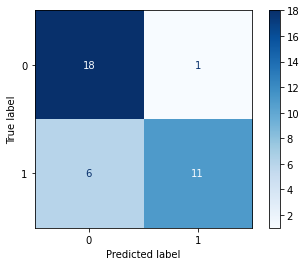

<Figure size 576x432 with 0 Axes>

In [626]:
evaluate_model(best_logistic_reg_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [627]:
cross_validation(best_logistic_reg_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.79310345 0.82142857 0.78571429 0.85714286 0.85714286]
Precision: [0.90909091 0.88888889 0.64705882 0.82352941 0.83333333]
Recall: [0.66666667 0.66666667 1.         0.93333333 0.9375    ]
F1 Score: [0.76923077 0.76190476 0.78571429 0.875      0.88235294]
ROC AUC Score: [0.94285714 0.80729167 0.85561497 0.85128205 0.84375   ]
Mean CV Accuracy: 0.8229064039408867
Mean CV Precision: 0.8203802733214497
Mean CV Recall: 0.8408333333333333
Mean CV F1 Score: 0.8148405516052574
Mean CV ROC AUC Score: 0.8601591668135786


In [628]:
# extract feature importances
#feature_importances = np.abs(best_logistic_reg.coef_).sum(axis=0)

#print("Feature Importances:")
#for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

Logistic Regression for Men

In [629]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=15, solver='liblinear')

grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 5, 'penalty': 'l1'}


In [630]:
best_logistic_reg_men = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=15)
best_logistic_reg_men.fit(X_train_val_men, y_train_val_men)

LogisticRegression(C=5, max_iter=1000, penalty='l1', random_state=15,
                   solver='liblinear')

Evaluation metrics for men:
Accuracy: 0.9166666666666666
Precision: 0.875
Recall: 0.9333333333333333
F1 Score: 0.9032258064516129
ROC AUC Score: 0.919047619047619


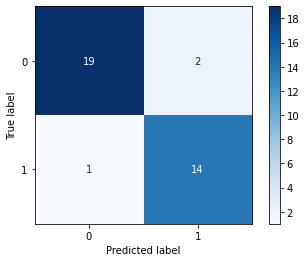

<Figure size 576x432 with 0 Axes>

In [631]:
evaluate_model(best_logistic_reg_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [632]:
cross_validation(best_logistic_reg_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [0.96551724 0.82758621 0.96551724 0.92857143 1.        ]
Precision: [1.         0.78571429 0.92307692 0.86666667 1.        ]
Recall: [0.9        0.84615385 1.         1.         1.        ]
F1 Score: [0.94736842 0.81481481 0.96       0.92857143 1.        ]
ROC AUC Score: [0.97368421 0.9375     0.99019608 0.93846154 1.        ]
Mean CV Accuracy: 0.9374384236453203
Mean CV Precision: 0.915091575091575
Mean CV Recall: 0.9492307692307692
Mean CV F1 Score: 0.930150932887775
Mean CV ROC AUC Score: 0.9679683654838455


Random Forest

In [633]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

Random Forest for Women

In [634]:
rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [635]:
best_rf_classifier_women = RandomForestClassifier(**best_params, random_state=15)
best_rf_classifier_women.fit(X_train_val_women, y_train_val_women)

RandomForestClassifier(max_depth=5, max_features='log2', n_estimators=50,
                       random_state=15)

Evaluation metrics for women:
Accuracy: 0.8611111111111112
Precision: 0.9285714285714286
Recall: 0.7647058823529411
F1 Score: 0.8387096774193549
ROC AUC Score: 0.8560371517027864


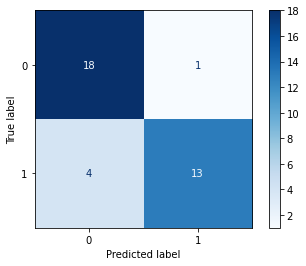

<Figure size 576x432 with 0 Axes>

In [636]:
evaluate_model(best_rf_classifier_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [637]:
cross_validation(best_rf_classifier_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.89655172 0.89285714 0.71428571 0.82142857 0.82142857]
Precision: [0.92857143 0.84615385 0.57894737 0.8125     0.86666667]
Recall: [0.86666667 0.91666667 1.         0.86666667 0.8125    ]
F1 Score: [0.89655172 0.88       0.73333333 0.83870968 0.83870968]
ROC AUC Score: [0.93333333 0.96875    0.95187166 0.84102564 0.91145833]
Mean CV Accuracy: 0.8293103448275861
Mean CV Precision: 0.8065678619625988
Mean CV Recall: 0.8925000000000001
Mean CV F1 Score: 0.8374608824619948
Mean CV ROC AUC Score: 0.9212877930892637


In [638]:
#feature_importances = best_rf_classifier.feature_importances_
#for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

Random Forest for Men

In [639]:
rf_classifier = RandomForestClassifier(random_state=15)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [640]:
best_rf_classifier_men = RandomForestClassifier(**best_params, random_state=15)
best_rf_classifier_men.fit(X_train_val_men, y_train_val_men)

RandomForestClassifier(max_features='log2', random_state=15)

Evaluation metrics for men:
Accuracy: 0.9444444444444444
Precision: 0.8823529411764706
Recall: 1.0
F1 Score: 0.9375
ROC AUC Score: 0.9523809523809523


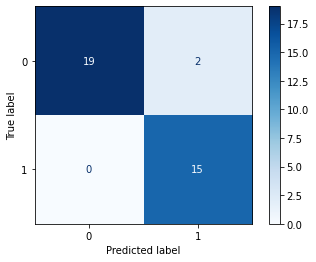

<Figure size 576x432 with 0 Axes>

In [641]:
evaluate_model(best_rf_classifier_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [642]:
cross_validation(best_rf_classifier_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [1.         0.93103448 0.93103448 0.92857143 1.        ]
Precision: [1.         0.86666667 0.91666667 0.86666667 1.        ]
Recall: [1.         1.         0.91666667 1.         1.        ]
F1 Score: [1.         0.92857143 0.91666667 0.92857143 1.        ]
ROC AUC Score: [1.         0.97115385 0.9877451  1.         1.        ]
Mean CV Accuracy: 0.958128078817734
Mean CV Precision: 0.93
Mean CV Recall: 0.9833333333333332
Mean CV F1 Score: 0.9547619047619047
Mean CV ROC AUC Score: 0.9917797888386124


Decision Trees

In [643]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

Decision Trees for Women

In [644]:
dec_tree_classifier = DecisionTreeClassifier(random_state=15)

grid_search = GridSearchCV(estimator=dec_tree_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


In [645]:
best_dec_tree_classifier_women = DecisionTreeClassifier(**best_params, random_state=15)
best_dec_tree_classifier_women.fit(X_train_val_women, y_train_val_women)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       min_samples_split=5, random_state=15)

Evaluation metrics for women:
Accuracy: 0.75
Precision: 0.7857142857142857
Recall: 0.6470588235294118
F1 Score: 0.7096774193548386
ROC AUC Score: 0.7445820433436532


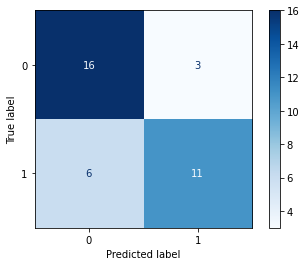

<Figure size 576x432 with 0 Axes>

In [646]:
evaluate_model(best_dec_tree_classifier_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [647]:
cross_validation(best_dec_tree_classifier_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.86206897 0.82142857 0.67857143 0.64285714 0.78571429]
Precision: [1.         0.81818182 0.55       0.72727273 0.85714286]
Recall: [0.73333333 0.75       1.         0.53333333 0.75      ]
F1 Score: [0.84615385 0.7826087  0.70967742 0.61538462 0.8       ]
ROC AUC Score: [0.91428571 0.82291667 0.72459893 0.73333333 0.91927083]
Mean CV Accuracy: 0.7581280788177339
Mean CV Precision: 0.7905194805194806
Mean CV Recall: 0.7533333333333333
Mean CV F1 Score: 0.7507649153090947
Mean CV ROC AUC Score: 0.8228810956200661


Decision Trees for Men

In [648]:
dec_tree_classifier = DecisionTreeClassifier(random_state=15)

grid_search = GridSearchCV(estimator=dec_tree_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [649]:
best_dec_tree_classifier_men = DecisionTreeClassifier(**best_params, random_state=15)
best_dec_tree_classifier_men.fit(X_train_val_men, y_train_val_men)

DecisionTreeClassifier(max_features='sqrt', random_state=15)

Evaluation metrics for men:
Accuracy: 0.9444444444444444
Precision: 0.8823529411764706
Recall: 1.0
F1 Score: 0.9375
ROC AUC Score: 0.9523809523809523


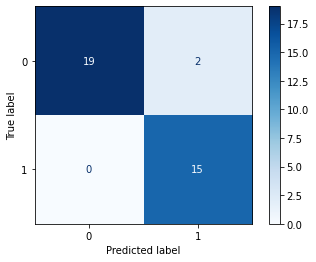

<Figure size 576x432 with 0 Axes>

In [650]:
evaluate_model(best_dec_tree_classifier_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [651]:
cross_validation(best_dec_tree_classifier_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [0.89655172 0.96551724 0.89655172 0.89285714 0.96428571]
Precision: [0.88888889 0.92857143 0.84615385 0.91666667 1.        ]
Recall: [0.8        1.         0.91666667 0.84615385 0.92857143]
F1 Score: [0.84210526 0.96296296 0.88       0.88       0.96296296]
ROC AUC Score: [0.87368421 0.96875    0.8995098  0.88974359 0.96428571]
Mean CV Accuracy: 0.9231527093596059
Mean CV Precision: 0.916056166056166
Mean CV Recall: 0.8982783882783882
Mean CV F1 Score: 0.9056062378167642
Mean CV ROC AUC Score: 0.9191946636954377


Support Vector Machine (SVM)

In [652]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

SVM for Women

In [653]:
svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'sigmoid'}


In [654]:
best_svm_women = SVC(**best_params, random_state=15)
best_svm_women.fit(X_train_val_women, y_train_val_women)

SVC(C=100, gamma=0.0001, kernel='sigmoid', random_state=15)

Evaluation metrics for women:
Accuracy: 0.8333333333333334
Precision: 0.8235294117647058
Recall: 0.8235294117647058
F1 Score: 0.8235294117647058
ROC AUC Score: 0.8328173374613003


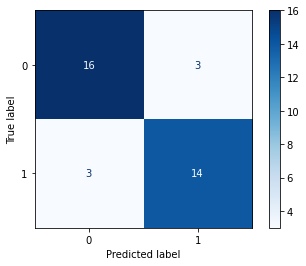

<Figure size 576x432 with 0 Axes>

In [655]:
evaluate_model(best_svm_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [656]:
cross_validation(best_svm_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.93103448 0.96428571 0.67857143 0.89285714 0.85714286]
Precision: [0.93333333 1.         0.55       0.83333333 0.875     ]
Recall: [0.93333333 0.91666667 1.         1.         0.875     ]
F1 Score: [0.93333333 0.95652174 0.70967742 0.90909091 0.875     ]
ROC AUC Score: [0.96666667 0.98958333 0.89839572 0.9025641  0.89583333]
Mean CV Accuracy: 0.8647783251231527
Mean CV Precision: 0.8383333333333333
Mean CV Recall: 0.945
Mean CV F1 Score: 0.8767246801819033
Mean CV ROC AUC Score: 0.9306086315645139


In [657]:
#perm_importance = permutation_importance(best_svm, X_train_women, y_train_women, n_repeats=10, random_state=15)
#feature_importance_scores = perm_importance.importances_mean
#for importance, feature in sorted(zip(feature_importance_scores, X_train_women.columns), reverse=True):
#    print(f"Feature {feature}: {importance}")

SVM for Men

In [658]:
svm = SVC(random_state=15)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [659]:
best_svm_men = SVC(**best_params, random_state=15)
best_svm_men.fit(X_train_val_men, y_train_val_men)

SVC(C=100, gamma=0.01, random_state=15)

Evaluation metrics for men:
Accuracy: 0.9722222222222222
Precision: 0.9375
Recall: 1.0
F1 Score: 0.967741935483871
ROC AUC Score: 0.9761904761904762


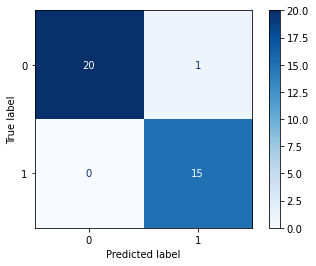

<Figure size 576x432 with 0 Axes>

In [660]:
evaluate_model(best_svm_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [661]:
cross_validation(best_svm_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [0.96551724 0.86206897 0.96551724 0.92857143 1.        ]
Precision: [1.         0.84615385 0.92307692 0.86666667 1.        ]
Recall: [0.9        0.84615385 1.         1.         1.        ]
F1 Score: [0.94736842 0.84615385 0.96       0.92857143 1.        ]
ROC AUC Score: [1.         0.95673077 1.         0.95384615 1.        ]
Mean CV Accuracy: 0.9443349753694582
Mean CV Precision: 0.9271794871794871
Mean CV Recall: 0.9492307692307692
Mean CV F1 Score: 0.9364187391555813
Mean CV ROC AUC Score: 0.9821153846153846


K-Nearest Neighbours

In [662]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],     
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

K-Nearest Neighbours for Women

In [663]:
knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_women, y_train_val_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}


In [664]:
best_knn_classifier_women = KNeighborsClassifier(**best_params)
best_knn_classifier_women.fit(X_train_val_women, y_train_val_women)

KNeighborsClassifier(metric='euclidean', n_neighbors=9)

Evaluation metrics for women:
Accuracy: 0.9166666666666666
Precision: 0.8888888888888888
Recall: 0.9411764705882353
F1 Score: 0.9142857142857143
ROC AUC Score: 0.9179566563467493


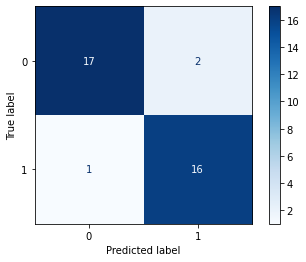

<Figure size 576x432 with 0 Axes>

In [665]:
evaluate_model(best_knn_classifier_women, X_test_women, y_test_women, 'women', best_params=best_params)

In [666]:
cross_validation(best_knn_classifier_women, X_train_val_women, y_train_val_women, 'women', kf=kf)

Cross-Validation Results:
Accuracy: [0.96551724 0.89285714 0.67857143 0.85714286 0.82142857]
Precision: [0.9375     0.8        0.55       0.82352941 0.82352941]
Recall: [1.         1.         1.         0.93333333 0.875     ]
F1 Score: [0.96774194 0.88888889 0.70967742 0.875      0.84848485]
ROC AUC Score: [0.95       0.93229167 0.85026738 0.88974359 0.87760417]
Mean CV Accuracy: 0.8431034482758621
Mean CV Precision: 0.7869117647058823
Mean CV Recall: 0.9616666666666667
Mean CV F1 Score: 0.8579586184424894
Mean CV ROC AUC Score: 0.8999813605512135


K-Nearest Neighbours for Men

In [667]:
knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val_men, y_train_val_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


In [668]:
best_knn_classifier_men = KNeighborsClassifier(**best_params)
best_knn_classifier_men.fit(X_train_val_men, y_train_val_men)

KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='distance')

Evaluation metrics for men:
Accuracy: 0.8888888888888888
Precision: 0.7894736842105263
Recall: 1.0
F1 Score: 0.8823529411764706
ROC AUC Score: 0.9047619047619048


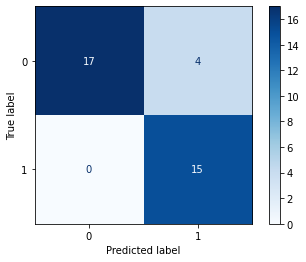

<Figure size 576x432 with 0 Axes>

In [669]:
evaluate_model(best_knn_classifier_men, X_test_men, y_test_men, 'men', best_params=best_params)

In [670]:
cross_validation(best_knn_classifier_men, X_train_val_men, y_train_val_men, 'men', kf=kf)

Cross-Validation Results:
Accuracy: [0.89655172 0.82758621 0.89655172 0.82142857 0.92857143]
Precision: [0.81818182 0.78571429 0.8        0.72222222 1.        ]
Recall: [0.9        0.84615385 1.         1.         0.85714286]
F1 Score: [0.85714286 0.81481481 0.88888889 0.83870968 0.92307692]
ROC AUC Score: [0.97368421 0.90384615 0.96078431 0.9025641  1.        ]
Mean CV Accuracy: 0.8741379310344828
Mean CV Precision: 0.8252236652236652
Mean CV Recall: 0.9206593406593406
Mean CV F1 Score: 0.8645266322685679
Mean CV ROC AUC Score: 0.9481757561324125
